# Word in Context (WiC) Classification Assignment

**Please pay attention to these notes:**
<br><br>

- The coding parts you need to implement are denoted by:
```
    #################################
    ## PUT YOU IMPLEMENTATION HERE ##
    #################################
```

- You must run this notebook on Google Colab platform, it depends on Google Colab VM for some of the depencecies. <b><font color='red'> You must also use the GPU runtime for faster training of the model. </font></b>
- <b><font color='red'>When you are ready to submit, please follow the instructions at the end of this notebook.</font></b>

<br>

--------------------------------------------------

In this assignment, you will implement a classifier that determines whether a word has the same meaning in two different sentences. You'll be using the WiC (Word in Context) dataset and BERT embeddings to solve this task.

First lets install the requirements:

In [1]:

#importing clear_output() function from notebook utilities
from IPython.display import clear_output

!pip install datasets

clear_output()
print('Done!')

Done!


## Dataset Description

The WiC dataset provides pairs of sentences where a target word appears in both sentences. Your task is to determine whether the word is used with the same sense (meaning) in both sentences. For example:

```
Sentence 1: "The house has a nice room."
Sentence 2: "There's not enough room for everyone."
Target word: "room"
Label: 0 (different meaning)
```

Each example in the dataset contains:
- `sentence1`: First sentence
- `sentence2`: Second sentence
- `word`: The target word
- `start1`  , `end1`: Character positions of the target word in sentence1
- `start2`  , `end2`: Character positions of the target word in sentence2
- `label`: 1 if the word has the same meaning in both sentences, 0 otherwise


In [4]:
# Lets take a look!

from datasets import load_dataset
from pprint import pprint

# Load dataset
dataset = load_dataset("super_glue", "wic",
                       trust_remote_code=True)

# Clear the output
clear_output()

print('The dataset blueprint is: ')
print(dataset)
print("============")
print('The first example of the train partition is: ')
pprint(dataset['train'][0])


# print(dataset)


KeyboardInterrupt: 

In [5]:
# ==================================================================================
#                    COPY THIS CELL INTO THE ASSIGNMENT NOTEBOOK                   #
# ==================================================================================

from IPython.display import clear_output


# we download the files of the full dataset from here
!pip install gdown
!gdown --folder https://drive.google.com/drive/folders/1ZFz8-p40Ywoe8oBHb6H8ihO-boQqiq6_ -O /content/

!pip install datasets

# Lets take a look!

from datasets import load_dataset
from pprint import pprint

# Load dataset

####### WARNING! The Hugging Face version of the dataset does not include the test labels.
####### However, you can obtain the full dataset by running the following script.
####### Be sure to execute the previous cell first.

dataset = load_dataset('./WiC/wic_loader.py',
                        data_dir='./WiC',
                        trust_remote_code=True)




# Clear the output
clear_output()

print('The dataset blueprint is: ')
print(dataset)
print("============")
print('The first example of the train partition is: ')
pprint(dataset['train'][0])

The dataset blueprint is: 
DatasetDict({
    train: Dataset({
        features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
        num_rows: 5428
    })
    validation: Dataset({
        features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
        num_rows: 638
    })
    test: Dataset({
        features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
        num_rows: 1400
    })
})
The first example of the train partition is: 
{'end1': 14,
 'end2': 13,
 'idx': 0,
 'label': 0,
 'sentence1': 'You must carry your camping gear .',
 'sentence2': 'Sound carries well over water .',
 'start1': 9,
 'start2': 6,
 'word': 'carry'}


## How to approach the problem?

To address this problem, we need a vector representation (embedding) of the target word in each of the two sentences. To achieve this, we first pass each sentence through the BERT model separately to obtain token embeddings. Next, we identify the sub-tokens corresponding to the target word in each sentence and compute their average embedding to represent the target word. Finally, we concatenate the two resulting vectors and feed them into a classifier, which determines whether the words share the same meaning based on these embeddings.

In order to identify the sub-tokens corresponding to the target word, you should implement the `find_target_token_indices` function (similar to what we had in the class), which takes three inputs:

- `start_idx`: The starting character index of the target word.
- `end_idx`: The ending character index of the target word.
- `offset_mapping`: A tensor containing character spans for each token in a tokenized sentence.

The function should return a binary mask indicating which tokens correspond to the target word. To achieve this, iterate through offset_mapping and check if each token’s character span overlaps with the target word’s span (start_idx to end_idx). If there is an overlap, mark that token’s index in the mask as 1; otherwise, keep it 0. Finally, return the binary mask.


Here is an example usage:

```python
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    sentence = "working with tokenizer is fun!."
    target_word = "tokenizer"
    start_idx = sentence.index(target_word)  # = 13
    end_idx = start_idx + len(target_word) # = 22
    
    encoding = tokenizer(sentence, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding["offset_mapping"][0] # get the first item to remove the tokenizer's batching
    input_ids = encoding["input_ids"][0] # get the first item to remove the tokenizer's batching

    mask = find_target_token_indices(start_idx, end_idx, offset_mapping)

    print((tokenizer.convert_ids_to_tokens(input_ids)))
   # >>> ['[CLS]', 'working', 'with', 'token', '##izer', 'is', 'fun', '!', '[SEP]']

    print(mask)
    # >>> tensor([0., 0., 0., 1., 1., 0., 0., 0., 0.])
```



In [6]:
import torch

def find_target_token_indices(start_idx, end_idx, offset_mapping):
    """
    Find token indices for a specific target word using offset mapping.

    Args:
        start_idx (int): Character start index of target word
        end_idx (int): Character end index of target word
        offset_mapping (torch.Tensor): Offset mapping from tokenization of the sentence

    Returns:
        torch.Tensor: Binary mask for target word tokens
    """
    mask = torch.zeros(offset_mapping.shape[0], dtype=torch.float)
    for i, (token_start, token_end) in enumerate(offset_mapping):
        # Check if the token overlaps with the target word span
        if token_start < end_idx and token_end > start_idx:
            mask[i] = 1.0  # Mark this token as part of the target word


    #################################
    ## PUT YOU IMPLEMENTATION HERE ##
    #################################

    return mask

Test you implementation!

Note: In this test, we remove the tokenizer's batching behavior when extracting `input_ids` and `offset_mapping` by selecting the first item (index `0`). Otherwise, the output would have two dimensions, with the first dimension that represents the batch always having a single item (length of 1), which is redundant since we only process a single sentence at a time (i.e., a batch size of one).

In [7]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Test case: Basic word detection
sentence = "Working with tokenizer is fun!"
target_word = "tokenizer"
start_idx = sentence.index(target_word)
end_idx = start_idx + len(target_word)
encoding = tokenizer(sentence, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding["offset_mapping"][0] # get the first item to remove the tokenizer's batching
input_ids = encoding["input_ids"][0] # get the first item to remove the tokenizer's batching

mask = find_target_token_indices(start_idx, end_idx, offset_mapping)

assert mask.shape == input_ids.shape, "Mask should have the same shape as input_ids"
assert mask.sum().item() > 0, "Target word indices should be masked"
assert (tokenizer.decode(input_ids[mask==1])) == "tokenizer", "Wrong word is masked!"

print("Simple test passed!")



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Simple test passed!


## WiCDataset class

The WiCDataset class implements a PyTorch Dataset for the Word-in-Context (WiC) task. It processes pairs of sentences where a target word appears in both, preparing the data for a model to determine if the word has the same meaning in both contexts.
The inputs are:

Inputs:
- `dataset` containing sentence pairs, target word indices, and labels;
- `tokenizer` : an instance of bert tokenizer;
- `max_length` : the max length parameter that we pass to the tokenizer when encoding a sentence.

When the `__getitem__` method is called, you should extract the sentence pairs, word indices, and labels for the dataset item at index `idx`. Then, tokenize both sentences with padding and truncation. Next, create target masks to highlight the word positions using the `find_target_token_indices` function you implemented earlier.  

Your output should be a dictionary containing the tokenized inputs, attention masks, target masks, the item label, and the target word.

Example usage:




```python
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = dataset = load_dataset("super_glue", "wic",
                       trust_remote_code=True)
wic_dataset = WiCDataset(dataset["train"], tokenizer)

# Get first instance
sample = wic_dataset[0]

# Print original sentences
print("Sentence 1:", dataset["train"]["sentence1"][0])
print("Sentence 2:", dataset["train"]["sentence2"][0])
print("Target word:", sample["word"])
print("Label:", sample["label"])

# Print tokenized output
print("\nTokenized sentence 1:",
      tokenizer.convert_ids_to_tokens(sample["input_ids1"]))

# Show target word position
print("\nTarget mask 1:", sample["target_mask1"])
print("Target mask 2:", sample["target_mask2"])

# Check attention masks (1 for tokens, 0 for padding)
print("\nAttention mask 1:", sample["attention_mask1"])
```



In [8]:
from torch.utils.data import Dataset
import torch

class WiCDataset(Dataset):
    """
    PyTorch Dataset for Word in Context tokenization.
    """
    def __init__(self, dataset, tokenizer, max_length=128):
      # Store the dataset and tokenizer
        # If a sliced dictionary is passed (e.g., dataset[:5]), convert it to list of examples for uniform handling
        if isinstance(dataset, dict):
            # Convert dict of lists to list of dicts for easy indexing
            data_list = []
            n_items = len(next(iter(dataset.values())))  # length of one of the fields
            for i in range(n_items):
                item = {key: dataset[key][i] for key in dataset.keys()}
                data_list.append(item)
            self.dataset = data_list
        else:
            # If already a HuggingFace Dataset object, use it directly
            self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length


        #################################
        ## PUT YOU IMPLEMENTATION HERE ##
        #################################

    def __len__(self):
      return len(self.dataset)

        #################################
        ## PUT YOU IMPLEMENTATION HERE ##
        #################################

    def __getitem__(self, idx):
      # Retrieve the sample (dict with fields) at the given index
        sample = self.dataset[idx]
        sent1 = sample['sentence1']
        sent2 = sample['sentence2']
        word = sample['word']
        start1, end1 = sample['start1'], sample['end1']
        start2, end2 = sample['start2'], sample['end2']
        label = sample['label']

        # Tokenize the first sentence with offsets, padding and truncation
        enc1 = self.tokenizer(
            sent1,
            return_offsets_mapping=True,
            padding='max_length', truncation=True,
            max_length=self.max_length, return_tensors="pt"
        )
        input_ids1 = enc1["input_ids"][0]           # tensor of token ids for sentence1
        attention_mask1 = enc1["attention_mask"][0] # tensor of attention mask for sentence1
        offsets1 = enc1["offset_mapping"][0]        # tensor of [start, end) char positions for each token in sentence1

        # Tokenize the second sentence similarly
        enc2 = self.tokenizer(
            sent2,
            return_offsets_mapping=True,
            padding='max_length', truncation=True,
            max_length=self.max_length, return_tensors="pt"
        )
        input_ids2 = enc2["input_ids"][0]
        attention_mask2 = enc2["attention_mask"][0]
        offsets2 = enc2["offset_mapping"][0]

        # Compute target word token masks for each sentence using the helper function
        target_mask1 = find_target_token_indices(start1, end1, offsets1)
        target_mask2 = find_target_token_indices(start2, end2, offsets2)

        # Convert label to torch tensor (ensure it's of type long for classification)
        label_tensor = torch.tensor(label, dtype=torch.long)

        #################################
        ## PUT YOU IMPLEMENTATION HERE ##
        #################################

        return {
            'input_ids1': input_ids1,             # Token IDs for first sentence
            'attention_mask1': attention_mask1,   # Attention mask for first sentence
            'input_ids2': input_ids2,             # Token IDs for second sentence
            'attention_mask2': attention_mask2,   # Attention mask for second sentence
            'target_mask1': target_mask1,         # Mask for target word tokens in first sentence
            'target_mask2': target_mask2,         # Mask for target word tokens in second sentence
            'label': label_tensor,               # Label (0 or 1) as a tensor
            'word': word                          # Target word string (for reference/testing)
        }

Test your WiCDataset:

In [9]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# A simple dataset to test
dataset_sample = dataset['train'][:5] # first 5 instances of train partition

# Simple tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create DataLoader
dataset_instance = WiCDataset(dataset_sample, tokenizer, max_length=15)
dataloader = DataLoader(dataset_instance, batch_size=5, shuffle=False)

# Testing the first batch
batch = next(iter(dataloader))
print(batch)

assert tokenizer.convert_ids_to_tokens(batch['input_ids1'][batch['target_mask1']==1]) == batch['word'], 'Wrong words masked!'
print('Simple test passed!')

{'input_ids1': tensor([[  101,  2017,  2442,  4287,  2115, 13215,  6718,  1012,   102,     0,
             0,     0,     0,     0,     0],
        [  101,  7696,  2442,  2175,  2083,  8041,  6833,  1012,   102,     0,
             0,     0,     0,     0,     0],
        [  101,  3338,  2019,  4862,  5638,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2002,  5078,  1037, 23407, 16195,  2007,  1037,  3384,  2452,
          1012,   102,     0,     0,     0],
        [  101,  1996,  2914,  1997,  2189,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'attention_mask1': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]), 'input_ids2': tensor([[  101,  2614,  7883,  2092,  2058,  2300,  1

## WiCClassifier torch module

To build a WiC classifier, create a PyTorch model that inherits from nn.Module. Your model should use a pre-trained BERT model to extract contextual embeddings and include a classifier for binary classification. The classifier should consist of a nn.Linear layer followed by a nn.ReLU activation. The input size of the linear layer should be 2 * bert_hidden_size (which is 768 for BERT, resulting in 1536), and the output size should be 2, equal to the number of our classes. The input size is doubled because the model concatenates two vectors of size 768—as we see later in `forward` method, each representing the target word embedding from one of the two sentences—before passing them to the classifier.

In the `__init__` method, store the BERT model as `self.bert`, and define the linear classifier with the appropriate input and output sizes and the relu activation function. After the linear layer, apply `nn.ReLU()` to introduce non-linearity and improve the model’s ability to capture complex patterns. You can stack different torch modules on top using `nn.Sequential` ([look at the PyTorch documentation for more details](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). This setup ensures that your model can effectively distinguish between the two classes.

The `forward` method should take six inputs: two sets of input IDs and attention masks, along with two target masks. First, pass these inputs through BERT to obtain the contextual embeddings for both sentences. Then, compute the target word representations using masked averaging: multiply the embeddings by the target mask to zero out the embeddings of subwords that do not belong to the target word, sum the remaining embeddings, and divide by the number of subword tokens of the target word. Finally, concatenate these average-pulled target word representations and pass the resulting vector through the classifier you initialized earlier to generate the prediction.

Note: At some point, you should be using the `unsqueeze()` method of torch tensors to ensure correct broadcasting (hint: when applying target masks to the extracted embeddings). Also, make sure that all operations maintain the batch dimension so that your model works correctly during training.

In [10]:
import torch.nn as nn

class WiCClassifier(nn.Module):
    def __init__(self, bert_model):
        """
        Initialize the WiCClassifier model.
        Args:
            bert_model (nn.Module): Pre-trained BERT model for contextual embeddings.
        """
        super().__init__()
        self.bert = bert_model  # store the BERT model to extract embeddings
        hidden_size = bert_model.config.hidden_size  # typically 768 for BERT-base
        # Define a linear classifier: maps concatenated embeddings (2*hidden_size) to 2 classes, then ReLU
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 2),
            nn.ReLU()
        )

    def forward(self, input_ids1, attention_mask1,
                      input_ids2, attention_mask2,
                      target_mask1, target_mask2):
        """
        Forward pass for the WiC classifier.
        Args:
            input_ids1, attention_mask1: token IDs and attention mask for first sentence.
            input_ids2, attention_mask2: token IDs and attention mask for second sentence.
            target_mask1, target_mask2: binary masks for target word tokens in each sentence.
        Returns:
            torch.Tensor: Logits for binary classification (shape: [batch_size, 2]).
        """
        # 1. Extract contextual embeddings for both sentences using BERT
        output1 = self.bert(input_ids1, attention_mask=attention_mask1)
        output2 = self.bert(input_ids2, attention_mask=attention_mask2)
        embeddings1 = output1.last_hidden_state  # shape: [batch_size, seq_len, hidden_size]
        embeddings2 = output2.last_hidden_state  # shape: [batch_size, seq_len, hidden_size]

        # 2. Compute target word representations by masked averaging
        # Unsqueeze target masks to shape [batch_size, seq_len, 1] for broadcasting
        mask1 = target_mask1.unsqueeze(-1)  # shape: [batch_size, seq_len, 1]
        mask2 = target_mask2.unsqueeze(-1)  # shape: [batch_size, seq_len, 1]
        # Zero out embeddings of tokens that are not the target word
        target_embeds1 = embeddings1 * mask1
        target_embeds2 = embeddings2 * mask2
        # Sum the embeddings of the target word tokens
        sum_embed1 = target_embeds1.sum(dim=1)  # shape: [batch_size, hidden_size]
        sum_embed2 = target_embeds2.sum(dim=1)  # shape: [batch_size, hidden_size]
        # Compute the number of target tokens in each sentence (summing the mask)
        count1 = mask1.sum(dim=1)  # shape: [batch_size, 1]
        count2 = mask2.sum(dim=1)  # shape: [batch_size, 1]
        # Avoid division by zero (in practice, count will be >=1 since target word exists)
        # Average the embeddings to get a single vector for the target word
        target_vec1 = sum_embed1 / count1  # [batch_size, hidden_size]
        target_vec2 = sum_embed2 / count2  # [batch_size, hidden_size]

        # 3. Concatenate the two target word representations
        combined_vec = torch.cat([target_vec1, target_vec2], dim=1)  # [batch_size, 2*hidden_size]

        # 4. Classify using the linear layer (followed by ReLU)
        logits = self.classifier(combined_vec)  # [batch_size, 2]
        return logits


## Train the model

You can train your model using the following code:

In [11]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
from transformers import AutoModel

num_epochs = 3
learning_rate = 2e-5
max_length=128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_dataset = WiCDataset(dataset['train'], tokenizer, max_length)
val_dataset = WiCDataset(dataset['validation'], tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


bert_model = AutoModel.from_pretrained('bert-base-uncased')
model = WiCClassifier(bert_model)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader)
    for batch in progress_bar:
        input_ids1 = batch['input_ids1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        target_mask1 = batch['target_mask1'].to(device)
        target_mask2 = batch['target_mask2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids1,
                        attention_mask1,
                        input_ids2,
                        attention_mask2,
                        target_mask1,
                        target_mask2)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({f"Loss": loss.item()})


    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:

            input_ids1 = batch['input_ids1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)
            target_mask1 = batch['target_mask1'].to(device)
            target_mask2 = batch['target_mask2'].to(device)
            labels = batch['label'].to(device)


            outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2, target_mask1, target_mask2)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} done!")
    print(f"Average training loss: {total_loss/len(train_loader):.4f}")
    print(f"Validation accuracy: {val_acc:.4f}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 170/170 [01:19<00:00,  2.14it/s, Loss=0.638]


Epoch 1/3 done!
Average training loss: 0.6745
Validation accuracy: 0.5815


100%|██████████| 170/170 [01:18<00:00,  2.17it/s, Loss=0.69]


Epoch 2/3 done!
Average training loss: 0.5661
Validation accuracy: 0.5705


100%|██████████| 170/170 [01:18<00:00,  2.18it/s, Loss=0.435]


Epoch 3/3 done!
Average training loss: 0.4341
Validation accuracy: 0.5815


The WiC dataset includes a test set, in addition to the train and validation sets. Write a code to evaluate your model on the test set of the WiC dataset and print out the accuracy, following a similar approach as we did in the training loop with the validation dataset.

In [17]:
test_dataset = WiCDataset(dataset['test'], tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=32)

# Ensure model is in evaluation mode
model.eval()

# Test set evaluation
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on test set"):
        input_ids1 = batch['input_ids1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        target_mask1 = batch['target_mask1'].to(device)
        target_mask2 = batch['target_mask2'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2, target_mask1, target_mask2)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Count correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute test accuracy
test_acc = correct / total
print(f"Test Set Accuracy: {test_acc:.4f}")


Evaluating on test set: 100%|██████████| 44/44 [00:11<00:00,  3.80it/s]


Test Set Accuracy: 0.5421


## Improve your model

This section is all yours! Try exploring a different approach to solving this task. You could experiment with modifying the classifier architecture—for example, adding more linear layers instead of using just one. Additionally, consider adjusting the training hyperparameters, such as increasing the number of training epochs, to improve performance.

Go ahead and implement your new model and training loop. Your updated training loop should also record the loss at each iteration. Once training is complete, visualize the recorded training loss values by plotting them using a library like Matplotlib. You must also aim for a final test accuracy in the range of 65–70%.

Epoch 1/5: 100%|██████████| 170/170 [00:40<00:00,  4.23it/s, Loss=0.666]


Epoch 1/5 - Avg Training Loss: 0.6916
Validation Accuracy: 0.5549


Epoch 2/5: 100%|██████████| 170/170 [00:40<00:00,  4.24it/s, Loss=0.701]


Epoch 2/5 - Avg Training Loss: 0.6551
Validation Accuracy: 0.5737


Epoch 3/5: 100%|██████████| 170/170 [00:40<00:00,  4.24it/s, Loss=0.608]


Epoch 3/5 - Avg Training Loss: 0.6208
Validation Accuracy: 0.6364


Epoch 4/5: 100%|██████████| 170/170 [00:40<00:00,  4.23it/s, Loss=0.57]


Epoch 4/5 - Avg Training Loss: 0.5905
Validation Accuracy: 0.6332


Epoch 5/5: 100%|██████████| 170/170 [00:40<00:00,  4.23it/s, Loss=0.526]


Epoch 5/5 - Avg Training Loss: 0.5573
Validation Accuracy: 0.6552


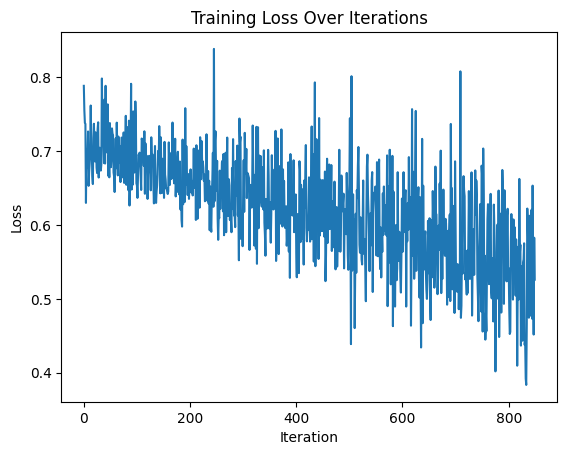

Validation accuracies per epoch: ['0.5549', '0.5737', '0.6364', '0.6332', '0.6552']


Evaluating on test set: 100%|██████████| 44/44 [00:05<00:00,  7.76it/s]

Test Set Accuracy: 0.6550


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model
from torch.optim.lr_scheduler import LambdaLR

# Load dataset and tokenizer
dataset = load_dataset('./WiC/wic_loader.py',
                        data_dir='./WiC',
                        trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# WiCDataset
class WiCDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        sent1, sent2 = sample['sentence1'], sample['sentence2']
        start1, end1 = sample['start1'], sample['end1']
        start2, end2 = sample['start2'], sample['end2']
        label = sample['label']

        enc1 = self.tokenizer(sent1, return_offsets_mapping=True, padding='max_length',
                              truncation=True, max_length=self.max_length, return_tensors="pt")
        enc2 = self.tokenizer(sent2, return_offsets_mapping=True, padding='max_length',
                              truncation=True, max_length=self.max_length, return_tensors="pt")

        return {
            'input_ids1': enc1["input_ids"][0], 'attention_mask1': enc1["attention_mask"][0],
            'input_ids2': enc2["input_ids"][0], 'attention_mask2': enc2["attention_mask"][0],
            'label': torch.tensor(label, dtype=torch.long)
        }

# WiCClassifier with LoRA
class WiCClassifier(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        hidden_size = bert_model.config.hidden_size
        combined_size = hidden_size * 4
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, 512),
            nn.ReLU(),
            nn.Dropout(p=0.45),
            nn.Linear(512, 2)
        )

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        output1 = self.bert(input_ids=input_ids1, attention_mask=attention_mask1).last_hidden_state[:, 0, :]
        output2 = self.bert(input_ids=input_ids2, attention_mask=attention_mask2).last_hidden_state[:, 0, :]

        mult = output1 * output2
        abs_diff = torch.abs(output1 - output2)
        combined_vec = torch.cat([output1, output2, mult, abs_diff], dim=1)

        return self.classifier(combined_vec)

# Print trainable params
def print_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())

    # Print total parameters in BERT
    bert_params = sum(p.numel() for p in model.bert.parameters())

    print(f"Total model parameters: {all_params:,}")
    print(f"Total BERT parameters: {bert_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({(trainable_params / all_params) * 100:.2f}%)")

# Training setup
num_epochs = 5
learning_rate = 2.5e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
train_dataset = WiCDataset(dataset['train'], tokenizer)
val_dataset = WiCDataset(dataset['validation'], tokenizer)
test_dataset = WiCDataset(dataset['test'], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load BERT with LoRA
base_bert = AutoModel.from_pretrained('bert-base-uncased')
lora_config = LoraConfig(r=12, lora_alpha=24, target_modules=["query", "value"], lora_dropout=0.1, task_type="FEATURE_EXTRACTION")
bert_model = get_peft_model(base_bert, lora_config)
model = WiCClassifier(bert_model).to(device)

# Optimizer, Loss, and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Early stopping parameters
patience = 3
best_val_acc = 0
patience_counter = 0

# Store losses and validation accuracies
losses = []
val_accs = []

# Training loop with validation
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress_bar:
        input_ids1 = batch['input_ids1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.item())
        progress_bar.set_postfix({'Loss': loss.item()})

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Training Loss: {avg_train_loss:.4f}")

    # Validation step
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids1 = batch['input_ids1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accs.append(val_acc)
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Plot training loss
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.show()

print("Validation accuracies per epoch:", [f"{acc:.4f}" for acc in val_accs])

# Test set evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on test set"):
        input_ids1 = batch['input_ids1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Set Accuracy: {test_acc:.4f}")




In [24]:
def print_trainable_parameters(model):
    # Count total parameters in the whole model
    all_params = sum(p.numel() for p in model.parameters())

    # Count total parameters in the BERT backbone
    bert_params = sum(p.numel() for p in model.bert.parameters())

    # Count only trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Compute percentage of trainable parameters
    trainable_percentage = (trainable_params / all_params) * 100

    # Print results
    print(f"Total model parameters: {all_params:,}")
    print(f"Total BERT parameters: {bert_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_percentage:.2f}%)")

# Example usage (Assuming 'model' is your LoRA-enhanced model)
print_trainable_parameters(model)


Total model parameters: 111,499,010
Total BERT parameters: 109,924,608
Trainable parameters: 2,016,770 (1.81%)


# Submission

Congratulations! You finished the assignment & you're ready to submit your work. Please follow the instructions:

1. Check and review your answers. Make sure all of the cell outputs are what you want.
2. Select File > Save.
3. **Fill your information** & run the cell bellow.
4. Run **Make Submission** cell, It may take several minutes and it may ask you for your credential.
5. Run **Download Submission** cell to obtain your submission as a zip file.
6. Grab the downloaded file (`dl_asg01__xx__xx.zip`) and hand it over.

## Fill your information (Run the cell)

In [25]:
#@title Enter your information & "RUN the cell!!" { run: "auto" }
student_id = "24029408" #@param {type:"string"}
student_name = "Omar Ibrahim" #@param {type:"string"}

print("your student id:", student_id)
print("your name:", student_name)


from pathlib import Path

ASSIGNMENT_PATH = Path('asg01')
ASSIGNMENT_PATH.mkdir(parents=True, exist_ok=True)

your student id: 24029408
your name: Omar Ibrahim


## Make Submission (Run the cell)

In [ ]:
#@title Make submission
! pip install -U --quiet PyDrive > /dev/null
! pip install -U --quiet jdatetime > /dev/null
! apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc > /dev/null

import os
import time
import yaml
import json
import jdatetime

from google.colab import files
from IPython.display import Javascript
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

asg_name = 'WiC_Finetuning'
script_save = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

submission_file_name = 'dl_asg01__%s__%s.zip'%(student_id, student_name.lower().replace(' ',  '_'))

sub_info = {
    'student_id': student_id,
    'student_name': student_name,
    'dateime': str(jdatetime.date.today()),
    'asg_name': asg_name
}
json.dump(sub_info, open('info.json', 'w'))

Javascript(script_save)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('%s.ipynb'%asg_name)

! jupyter nbconvert --to script "$asg_name".ipynb > /dev/null
! jupyter nbconvert --to pdf "$asg_name".ipynb > /dev/null

! zip "$submission_file_name" "$asg_name".ipynb "$asg_name".html "$asg_name".txt info.json > /dev/null

print("##########################################")
print("Done! Submisson created, Please download using the bellow cell!")

Extracting templates from packages: 100%


In [18]:
drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']

'1T89PJk40_nK2Wy0s7M6QCXCFkGKXETho'

In [19]:
files.download(submission_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>